<a href="https://colab.research.google.com/github/pranay8297/course-collaboration-travel-plans/blob/master/camvid_own.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls() 

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_img = path/'images'
path_lbl = path/'labels'

In [5]:
images = get_image_files(path_img)
images[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00750.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_010320.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00450.png')]

In [6]:
labels = get_image_files(path_lbl)
labels[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_008670_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_02190_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_007650_P.png')]

In [0]:
def get_y_fn(x):
  file_name = x.name.split('.')[0] + '_P.png' 
  return path_lbl/file_name 

In [8]:
image_label = get_y_fn(images[0])
image_label

PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f00750_P.png')

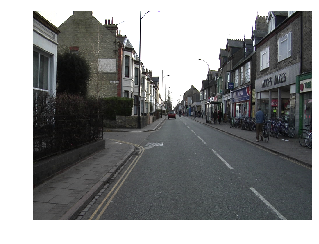

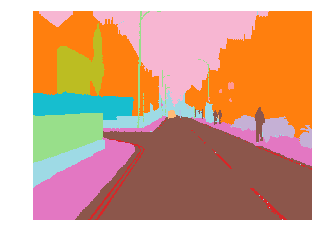

In [9]:
img_f = open_image(images[0])
lbl_f = open_mask(image_label)
img_f.show(figsize = (5, 5))
lbl_f.show(figsize = (5, 5), alpha = 1)

In [10]:
src_size = np.array(lbl_f.shape[1:])
src_size

array([720, 960])

In [11]:
lbl_f.data

tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]]])

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype = str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
size = src_size//2
free_mem = gpu_mem_get_free_no_cache()
bs = 4
if free_mem > 8200:
  bs = 8
  
print("free memory availabe is {} and batch size is {}".format(free_mem, bs))

free memory availabe is 11430 and batch size is 8


In [0]:
src = (SegmentationItemList.from_folder(path_img).split_by_fname_file(path/'valid.txt').label_from_func(get_y_fn, classes = codes))

In [0]:
data = (src.transform(get_transforms(), size = size, tfm_y = True).databunch(bs = bs).normalize(imagenet_stats))

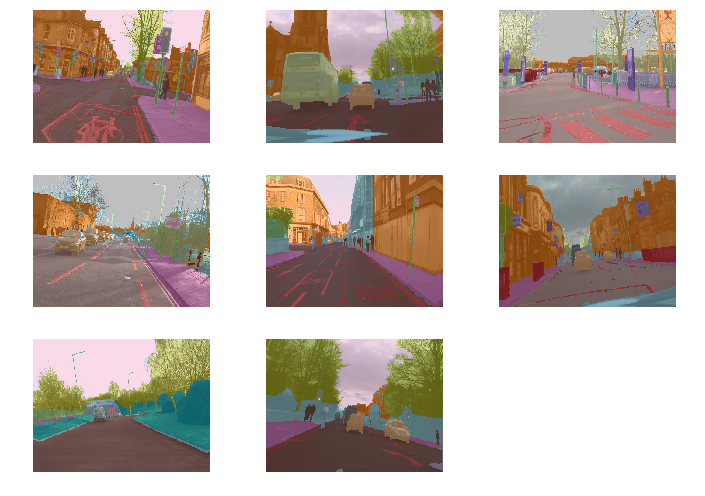

In [16]:
data.show_batch(rows = 3, figsize = (10, 7))

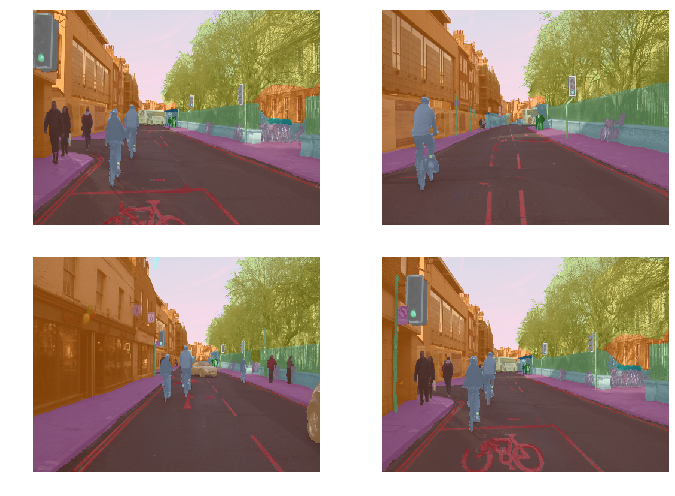

In [17]:
data.show_batch(rows = 2, figsize = (10, 7), ds_type = DatasetType.Valid)

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
void_code

30

In [0]:
def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim = 1)[mask] == target[mask]).float().mean()

In [20]:
learn = unet_learner(data, models.resnet34, metrics = acc_camvid, wd = 1e-2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 89780702.81it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


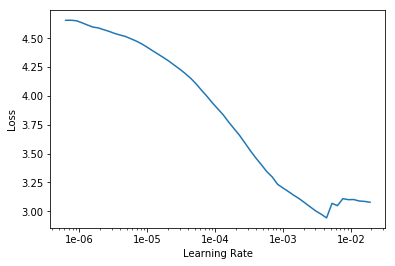

In [21]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 8e-04

In [24]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.425934,0.865062,0.755067,03:31
1,0.905178,0.683609,0.815630,03:20
2,0.717099,0.568659,0.849188,03:20
3,0.607623,0.543732,0.860519,03:19
4,0.545937,0.442749,0.874492,03:19
5,0.482607,0.402447,0.887207,03:19
6,0.421185,0.342170,0.900860,03:19
7,0.377927,0.331918,0.898638,03:19
8,0.343911,0.290637,0.917442,03:19
9,0.324478,0.292286,0.916887,03:19


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


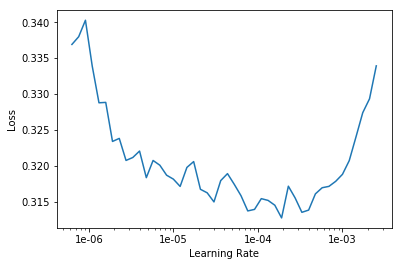

In [25]:
lr_find(learn)
learn.recorder.plot()

In [0]:
learn.save("st-1-l")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


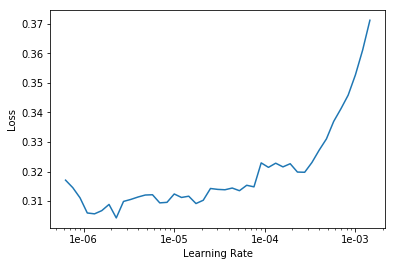

In [27]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot()

In [0]:
learn.save("st-2-ul")

In [28]:
learn.load('st-1-l')
st1_lr = 9e-05
learn.fit_one_cycle(10, st1_lr)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.320417,0.292279,0.918164,03:27
1,0.320284,0.298474,0.915883,03:28
2,0.330274,0.314294,0.909806,03:28
3,0.315591,0.283091,0.918474,03:28
4,0.306571,0.296627,0.915529,03:27
5,0.291361,0.275267,0.921653,03:28
6,0.281190,0.276185,0.922142,03:28
7,0.267399,0.266887,0.925089,03:28
8,0.259181,0.266590,0.925066,03:28
9,0.254105,0.269141,0.924306,03:28


In [32]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(9e-6, 6e-5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.256089,0.262718,0.926124,03:28
1,0.255494,0.271048,0.923968,03:28
2,0.259373,0.265060,0.924995,03:28
3,0.253275,0.285524,0.917485,03:27
4,0.245736,0.284494,0.918293,03:28
5,0.237777,0.272582,0.922788,03:28
6,0.233993,0.277446,0.920388,03:28
7,0.228841,0.266557,0.924568,03:26
8,0.225830,0.270714,0.923499,03:26
9,0.222284,0.272331,0.923146,03:26


ValueError: ignored

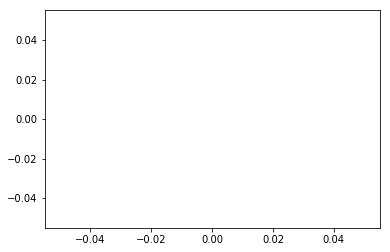

In [36]:
size = src_size//2
data = (src.transform(get_transforms(), size = size, tfm_y = True).databunch(bs = 4).normalize(imagenet_stats))
learn.data = data
learn.recorder.plot_losses()